#Installation de pyspark

In [15]:
!pip install pyspark

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importation des packages

In [68]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, regexp_replace, count, avg, mode, coalesce, udf, sum, lit, expr, regexp_extract
from pyspark.sql.types import IntegerType

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
import matplotlib.pyplot as plt
from pyspark.ml.regression import RandomForestRegressor
from ipywidgets import interact, widgets
import pandas as pd

#Importer les données

In [5]:
# Initialiser une session Spark
spark = SparkSession.builder \
    .appName("Check Missing Data") \
    .getOrCreate()

# Chemin vers le fichier JSON
file_path = "/content/drive/MyDrive/olympic_athletes.json"

# Charger les données JSON dans un DataFrame
df = spark.read.json(file_path)

# Afficher le DataFrame
df.show(truncate=False)

+----------------------+------------------------------+-------------------------------------------------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Nombre total de ligne du Dataframe

In [35]:
num_lines = df.count()

# Afficher le nombre total de lignes
print(f"Nombre total de lignes : {num_lines}")

Nombre total de lignes : 75904


#Vérifier les données manquantes

In [36]:
missing_data_df = df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns])

# Afficher les résultats
missing_data_df.show()

+-----------------+--------------+-----------+------------------+-----+----------+--------------------+
|athlete_full_name|athlete_medals|athlete_url|athlete_year_birth|  bio|first_game|games_participations|
+-----------------+--------------+-----------+------------------+-----+----------+--------------------+
|                0|         60552|          0|              2456|53062|        22|                   0|
+-----------------+--------------+-----------+------------------+-----+----------+--------------------+



#Afficher le type des colonnes

In [37]:
df.dtypes

[('athlete_full_name', 'string'),
 ('athlete_medals', 'string'),
 ('athlete_url', 'string'),
 ('athlete_year_birth', 'double'),
 ('bio', 'string'),
 ('first_game', 'string'),
 ('games_participations', 'bigint')]

#Afficher les données d'une athlète

In [38]:
# Afficher les données de l'athlète "Mari EDER"
athlete_data = df.filter(df["athlete_full_name"] == "Mari EDER")

# Afficher les données de l'athlète
athlete_data.show(truncate=False)

+-----------------+--------------+------------------------------------------+------------------+----+----------+--------------------+
|athlete_full_name|athlete_medals|athlete_url                               |athlete_year_birth|bio |first_game|games_participations|
+-----------------+--------------+------------------------------------------+------------------+----+----------+--------------------+
|Mari EDER        |NULL          |https://olympics.com/en/athletes/mari-eder|1987.0            |NULL|NULL      |0                   |
+-----------------+--------------+------------------------------------------+------------------+----+----------+--------------------+



#Supprimer la colonne "bio"

In [39]:
cleaned_df = df.drop('bio')

# Afficher les 3 premières lignes
cleaned_df.show(3, truncate=False)

+----------------------+--------------+-------------------------------------------------------+------------------+----------------+--------------------+
|athlete_full_name     |athlete_medals|athlete_url                                            |athlete_year_birth|first_game      |games_participations|
+----------------------+--------------+-------------------------------------------------------+------------------+----------------+--------------------+
|Cooper WOODS-TOPALOVIC|NULL          |https://olympics.com/en/athletes/cooper-woods-topalovic|2000.0            |Beijing 2022    |1                   |
|Felix ELOFSSON        |NULL          |https://olympics.com/en/athletes/elofsson              |1995.0            |PyeongChang 2018|2                   |
|Dylan WALCZYK         |NULL          |https://olympics.com/en/athletes/dylan-walczyk         |1993.0            |Beijing 2022    |1                   |
+----------------------+--------------+-------------------------------------------

# Nettoyer la colonne 'athlete_medals'

In [40]:
# Remplacer les valeurs null par 0 et enlever les '\\n'
cleaned_df = cleaned_df.withColumn('athlete_medals',
                           when(cleaned_df['athlete_medals'].isNull(), '0')
                           .otherwise(regexp_replace('athlete_medals', '\\n', '')))

# Afficher les 10 premières lignes
cleaned_df.show(10, truncate=False)

+----------------------+--------------+-------------------------------------------------------+------------------+----------------+--------------------+
|athlete_full_name     |athlete_medals|athlete_url                                            |athlete_year_birth|first_game      |games_participations|
+----------------------+--------------+-------------------------------------------------------+------------------+----------------+--------------------+
|Cooper WOODS-TOPALOVIC|0             |https://olympics.com/en/athletes/cooper-woods-topalovic|2000.0            |Beijing 2022    |1                   |
|Felix ELOFSSON        |0             |https://olympics.com/en/athletes/elofsson              |1995.0            |PyeongChang 2018|2                   |
|Dylan WALCZYK         |0             |https://olympics.com/en/athletes/dylan-walczyk         |1993.0            |Beijing 2022    |1                   |
|Olli PENTTALA         |0             |https://olympics.com/en/athletes/olli-pentt

In [41]:
# Vérifier les données manquantes
missing_data_df = cleaned_df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in cleaned_df.columns])

missing_data_df.show()

+-----------------+--------------+-----------+------------------+----------+--------------------+
|athlete_full_name|athlete_medals|athlete_url|athlete_year_birth|first_game|games_participations|
+-----------------+--------------+-----------+------------------+----------+--------------------+
|                0|             0|          0|              2456|        22|                   0|
+-----------------+--------------+-----------+------------------+----------+--------------------+



# Nettoyer la colonne 'athlete_year_birth'

In [42]:
# Convertir la colonne en type Integer
cleaned_df = cleaned_df.withColumn("athlete_year_birth", col("athlete_year_birth").cast(IntegerType()))

# Remplacer les valeurs null par la moyenne des années de naissance
avg_year_birth = cleaned_df.select(avg("athlete_year_birth")).collect()[0][0]
cleaned_df = cleaned_df.fillna(avg_year_birth, subset=["athlete_year_birth"])

# Afficher les 10 premières lignes
cleaned_df.show(10, truncate=False)

+----------------------+--------------+-------------------------------------------------------+------------------+----------------+--------------------+
|athlete_full_name     |athlete_medals|athlete_url                                            |athlete_year_birth|first_game      |games_participations|
+----------------------+--------------+-------------------------------------------------------+------------------+----------------+--------------------+
|Cooper WOODS-TOPALOVIC|0             |https://olympics.com/en/athletes/cooper-woods-topalovic|2000              |Beijing 2022    |1                   |
|Felix ELOFSSON        |0             |https://olympics.com/en/athletes/elofsson              |1995              |PyeongChang 2018|2                   |
|Dylan WALCZYK         |0             |https://olympics.com/en/athletes/dylan-walczyk         |1993              |Beijing 2022    |1                   |
|Olli PENTTALA         |0             |https://olympics.com/en/athletes/olli-pentt

In [44]:
cleaned_df.dtypes

[('athlete_full_name', 'string'),
 ('athlete_medals', 'string'),
 ('athlete_url', 'string'),
 ('athlete_year_birth', 'int'),
 ('first_game', 'string'),
 ('games_participations', 'bigint')]

In [43]:
# Vérifier les données manquantes
missing_data_df = cleaned_df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in cleaned_df.columns])

missing_data_df.show()

+-----------------+--------------+-----------+------------------+----------+--------------------+
|athlete_full_name|athlete_medals|athlete_url|athlete_year_birth|first_game|games_participations|
+-----------------+--------------+-----------+------------------+----------+--------------------+
|                0|             0|          0|                 0|        22|                   0|
+-----------------+--------------+-----------+------------------+----------+--------------------+



#Nettoyer la colonne 'first_game'

In [45]:
# Remplacer les valeurs null par le mode
mode_first_game = cleaned_df.select(mode("first_game")).collect()[0][0]
cleaned_df = cleaned_df.fillna(mode_first_game, subset=["first_game"])

# Afficher les 10 premières lignes
cleaned_df.show(10, truncate=False)

+----------------------+--------------+-------------------------------------------------------+------------------+----------------+--------------------+
|athlete_full_name     |athlete_medals|athlete_url                                            |athlete_year_birth|first_game      |games_participations|
+----------------------+--------------+-------------------------------------------------------+------------------+----------------+--------------------+
|Cooper WOODS-TOPALOVIC|0             |https://olympics.com/en/athletes/cooper-woods-topalovic|2000              |Beijing 2022    |1                   |
|Felix ELOFSSON        |0             |https://olympics.com/en/athletes/elofsson              |1995              |PyeongChang 2018|2                   |
|Dylan WALCZYK         |0             |https://olympics.com/en/athletes/dylan-walczyk         |1993              |Beijing 2022    |1                   |
|Olli PENTTALA         |0             |https://olympics.com/en/athletes/olli-pentt

In [46]:
# Vérifier les données manquantes
missing_data_df = cleaned_df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in cleaned_df.columns])

missing_data_df.show()

+-----------------+--------------+-----------+------------------+----------+--------------------+
|athlete_full_name|athlete_medals|athlete_url|athlete_year_birth|first_game|games_participations|
+-----------------+--------------+-----------+------------------+----------+--------------------+
|                0|             0|          0|                 0|         0|                   0|
+-----------------+--------------+-----------+------------------+----------+--------------------+



#Comparaison des données de la même athlète

In [47]:
# Afficher les données de l'athlète avec le nom "Mari EDER"
athlete_data = cleaned_df.filter(cleaned_df["athlete_full_name"] == "Mari EDER")

# Afficher les données de l'athlète
athlete_data.show(truncate=False)

+-----------------+--------------+------------------------------------------+------------------+----------+--------------------+
|athlete_full_name|athlete_medals|athlete_url                               |athlete_year_birth|first_game|games_participations|
+-----------------+--------------+------------------------------------------+------------------+----------+--------------------+
|Mari EDER        |0             |https://olympics.com/en/athletes/mari-eder|1987              |Rio 2016  |0                   |
+-----------------+--------------+------------------------------------------+------------------+----------+--------------------+



#Téléchargement le nouveau fichier json avec les données nettoyées

In [53]:
# Nouveau nom pour le fichier JSON de sortie
output_file_path = "olympic_athletes_clean.json"

# Collecter les données au format JSON dans une seule chaîne
json_data = cleaned_df.toJSON().collect()

# Enregistrer les données dans un fichier JSON
with open(output_file_path, 'w') as f:
    f.write('[' + ',\n'.join(json_data) + ']')


#Ajouter les nouvelles colonnes dans la table "athletes"

In [18]:
# Initialiser une session Spark
spark = SparkSession.builder \
    .appName("New column") \
    .getOrCreate()

# Chemins vers les fichiers JSON
summer_file_path = "/content/drive/MyDrive/summer_results.json"
athletes_file_path = "/content/drive/MyDrive/olympic_athletes_clean.json"

# Charger les données JSON dans des DataFrames
df_summer = spark.read.json(summer_file_path)
df_athletes = spark.read.json(athletes_file_path)

# Afficher les DataFrames pour vérifier les données chargées
df_summer.show(truncate=False)
df_athletes.show(truncate=False)

# Sélectionner uniquement les colonnes nécessaires de df_summer
df_summer_selected = df_summer.select("athlete_url", "country_3_letter_code", "event_title", "discipline_title")

# Réaliser la jointure sur la colonne athlete_url
df_merged = df_athletes.join(df_summer_selected, on="athlete_url", how="left")

# Ajouter les colonnes country_3_letter_code, event_title et discipline_title au DataFrame df_athletes
df_updated_athletes = df_merged.withColumn(
    "country_3_letter_code",
    coalesce(df_merged["country_3_letter_code"], df_summer_selected["country_3_letter_code"])
).withColumn(
    "event_title",
    coalesce(df_merged["event_title"], df_summer_selected["event_title"])
).withColumn(
    "discipline_title",
    coalesce(df_merged["discipline_title"], df_summer_selected["discipline_title"])
)

# Afficher le DataFrame final pour vérifier le résultat
df_updated_athletes.show(truncate=False)

+---------------------------------------------------------------------------------------+-----------+------------------------------------+---------------------+----------------+------------------------------+---------+----------+--------------------------+----------------+----------+-------------+-----------+--------+-------+
|_corrupt_record                                                                        |athlete_url|comment                             |country_3_letter_code|discipline_title|event_title                   |id_result|medal_type|name                      |participant_type|rank_equal|rank_position|slug_game  |type    |version|
+---------------------------------------------------------------------------------------+-----------+------------------------------------+---------------------+----------------+------------------------------+---------+----------+--------------------------+----------------+----------+-------------+-----------+--------+-------+
|[              

#Vérification des valeurs manquantes dans les nouvelles colonnes

In [19]:
# Vérifier les données manquantes dans la colonne country_3_letter_code
missing_country_code = df_updated_athletes.filter(df_updated_athletes["country_3_letter_code"].isNull())

# Afficher les lignes avec des valeurs null dans country_3_letter_code
print("Lignes avec des valeurs null dans la colonne country_3_letter_code :")
missing_country_code.show(truncate=False)

# Compter le nombre de lignes avec des valeurs null dans country_3_letter_code
missing_count = missing_country_code.count()
print(f"Nombre de lignes avec des valeurs null dans la colonne country_3_letter_code : {missing_count}")

# Vérifier les données manquantes dans la colonne event_title
missing_event_title = df_updated_athletes.filter(df_updated_athletes["event_title"].isNull())

# Afficher les lignes avec des valeurs null dans event_title
print("Lignes avec des valeurs null dans la colonne event_title :")
missing_event_title.show(truncate=False)

# Compter le nombre de lignes avec des valeurs null dans event_title
missing_event_title_count = missing_event_title.count()
print(f"Nombre de lignes avec des valeurs null dans la colonne event_title : {missing_event_title_count}")

# Vérifier les données manquantes dans la colonne discipline_title
missing_discipline_title = df_updated_athletes.filter(df_updated_athletes["discipline_title"].isNull())

# Afficher les lignes avec des valeurs null dans discipline_title
print("Lignes avec des valeurs null dans la colonne discipline_title :")
missing_discipline_title.show(truncate=False)

# Compter le nombre de lignes avec des valeurs null dans discipline_title
missing_discipline_title_count = missing_discipline_title.count()
print(f"Nombre de lignes avec des valeurs null dans la colonne discipline_title : {missing_discipline_title_count}")

Lignes avec des valeurs null dans la colonne country_3_letter_code :
+-------------------------------------------------------+----------------------+--------------+------------------+----------------+--------------------+---------------------+-----------+----------------+
|athlete_url                                            |athlete_full_name     |athlete_medals|athlete_year_birth|first_game      |games_participations|country_3_letter_code|event_title|discipline_title|
+-------------------------------------------------------+----------------------+--------------+------------------+----------------+--------------------+---------------------+-----------+----------------+
|https://olympics.com/en/athletes/cooper-woods-topalovic|Cooper WOODS-TOPALOVIC|0             |2000              |Beijing 2022    |1                   |NULL                 |NULL       |NULL            |
|https://olympics.com/en/athletes/elofsson              |Felix ELOFSSON        |0             |1995              |P

#Vérification des doublons dans la colonne clé 'athlete_url'

In [20]:
duplicates = df_updated_athletes.groupBy("athlete_url").count().filter("count > 1")

# Afficher les doublons
if duplicates.count() > 0:
    print("Doublons trouvés dans la colonne 'athlete_url' :")
    duplicates.show(truncate=False)

    # Supprimer les doublons en conservant la première occurrence
    df_updated_athletes = df_updated_athletes.dropDuplicates(["athlete_url"])
    print("Doublons supprimés. DataFrame mis à jour :")
    df_updated_athletes.show(truncate=False)
else:
    print("Aucun doublon trouvé dans la colonne 'athlete_url'.")

Doublons trouvés dans la colonne 'athlete_url' :
+---------------------------------------------------------+-----+
|athlete_url                                              |count|
+---------------------------------------------------------+-----+
|https://olympics.com/en/athletes/alessandra-perilli      |3    |
|https://olympics.com/en/athletes/grace-brown             |2    |
|https://olympics.com/en/athletes/long-ma                 |2    |
|https://olympics.com/en/athletes/lexi-thompson           |2    |
|https://olympics.com/en/athletes/otgontsetseg-galbadrakh |2    |
|https://olympics.com/en/athletes/toma-nikiforov          |2    |
|https://olympics.com/en/athletes/nico-mueller            |2    |
|https://olympics.com/en/athletes/merel-blom              |2    |
|https://olympics.com/en/athletes/sergei-komissarov       |2    |
|https://olympics.com/en/athletes/james-andrew-davis      |2    |
|https://olympics.com/en/athletes/david-katoatau          |3    |
|https://olympics.com/en/at

In [13]:
# Vérifier les doublons dans la colonne 'athlete_full_name'
duplicates = df_updated_athletes.groupBy("athlete_url").count().filter("count > 1")

# Afficher les doublons
if duplicates.count() > 0:
    print("Doublons trouvés dans la colonne 'athlete_full_name' :")
    duplicates.show(truncate=False)
else:
    print("Aucun doublon trouvé dans la colonne 'athlete_full_name'.")

Aucun doublon trouvé dans la colonne 'athlete_full_name'.


#Téléchargement du nouveau fichier json

In [27]:
# Nouveau fichier JSON de sortie
output_file_path = "athletes_final.json"

# Collecter les données au format JSON dans une seule chaîne
json_data = df_updated_athletes.toJSON().collect()

# Enregistrer les données dans un fichier JSON
with open(output_file_path, 'w') as f:
    f.write('[' + ',\n'.join(json_data) + ']')

#Modèle

In [133]:
# Initialiser une session Spark
spark = SparkSession.builder \
    .appName("Modele Data") \
    .getOrCreate()

# Chemin vers le fichier JSON
file_path = "/content/athletes_final.json"

# Charger les données JSON dans un DataFrame
df = spark.read.json(file_path)

# Afficher le DataFrame
df.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+--------------+-------------------------------------------------------+------------------+---------------------+-------------------+------------------------------+-------------------+--------------------+
|_corrupt_record                                                                                                                                                                                                                                                                                                               |athlete_full_name     |athlete_medals|athlete_url                                            |athlete_year_birth|country_3_letter_co

In [134]:
# Filtrer les enregistrements corrompus
df = df.filter(df["_corrupt_record"].isNull())

# Supprimer les colonnes inutiles
df = df.drop("_corrupt_record")

# Afficher le schéma du DataFrame
df.printSchema()

# Afficher les statistiques descriptives
df.describe().show()

# Afficher les premières lignes du DataFrame
df.show(truncate=False)


root
 |-- athlete_full_name: string (nullable = true)
 |-- athlete_medals: string (nullable = true)
 |-- athlete_url: string (nullable = true)
 |-- athlete_year_birth: long (nullable = true)
 |-- country_3_letter_code: string (nullable = true)
 |-- discipline_title: string (nullable = true)
 |-- event_title: string (nullable = true)
 |-- first_game: string (nullable = true)
 |-- games_participations: long (nullable = true)

+-------+-----------------+--------------+--------------------+------------------+---------------------+----------------+--------------------+----------------+--------------------+
|summary|athlete_full_name|athlete_medals|         athlete_url|athlete_year_birth|country_3_letter_code|discipline_title|         event_title|      first_game|games_participations|
+-------+-----------------+--------------+--------------------+------------------+---------------------+----------------+--------------------+----------------+--------------------+
|  count|            75899|  

In [135]:
# Afficher la colonne athlete_medals avant l'extraction des chiffres
print("Avant l'extraction des chiffres :")
df.select("athlete_medals").show(5)

# Expression régulière pour extraire le chiffre précédant chaque lettre
gold_regex = r'(\d*)G'
silver_regex = r'(\d*)S'
bronze_regex = r'(\d*)B'

# Extraire le chiffre précédant chaque lettre
df = df.withColumn("gold_medals", regexp_extract(col("athlete_medals"), gold_regex, 1))
df = df.withColumn("silver_medals", regexp_extract(col("athlete_medals"), silver_regex, 1))
df = df.withColumn("bronze_medals", regexp_extract(col("athlete_medals"), bronze_regex, 1))

# Remplacer les valeurs vides par 0
df = df.withColumn("gold_medals", when(df["gold_medals"] == "", "0").otherwise(df["gold_medals"]))
df = df.withColumn("silver_medals", when(df["silver_medals"] == "", "0").otherwise(df["silver_medals"]))
df = df.withColumn("bronze_medals", when(df["bronze_medals"] == "", "0").otherwise(df["bronze_medals"]))

# Convertir les colonnes en entiers
df = df.withColumn("gold_medals", col("gold_medals").cast("integer"))
df = df.withColumn("silver_medals", col("silver_medals").cast("integer"))
df = df.withColumn("bronze_medals", col("bronze_medals").cast("integer"))

# Afficher les colonnes gold_medals, silver_medals et bronze_medals après l'extraction
print("Après l'extraction des chiffres :")
df.select("gold_medals", "silver_medals", "bronze_medals").show(5)

# Calculer le total de médailles pour chaque athlète
df = df.withColumn("total_medals", col("gold_medals") + col("silver_medals") + col("bronze_medals"))

# Afficher les résultats finaux
print("Résultats finaux :")
df.show()

Avant l'extraction des chiffres :
+--------------+
|athlete_medals|
+--------------+
|             0|
|             0|
|            1S|
|             0|
|          1G2S|
+--------------+
only showing top 5 rows

Après l'extraction des chiffres :
+-----------+-------------+-------------+
|gold_medals|silver_medals|bronze_medals|
+-----------+-------------+-------------+
|          0|            0|            0|
|          0|            0|            0|
|          0|            1|            0|
|          0|            0|            0|
|          1|            2|            0|
+-----------+-------------+-------------+
only showing top 5 rows

Résultats finaux :
+--------------------+--------------+--------------------+------------------+---------------------+-------------------+--------------------+-------------------+--------------------+-----------+-------------+-------------+------------+
|   athlete_full_name|athlete_medals|         athlete_url|athlete_year_birth|country_3_letter_cod

In [136]:
df.dtypes

[('athlete_full_name', 'string'),
 ('athlete_medals', 'string'),
 ('athlete_url', 'string'),
 ('athlete_year_birth', 'bigint'),
 ('country_3_letter_code', 'string'),
 ('discipline_title', 'string'),
 ('event_title', 'string'),
 ('first_game', 'string'),
 ('games_participations', 'bigint'),
 ('gold_medals', 'int'),
 ('silver_medals', 'int'),
 ('bronze_medals', 'int'),
 ('total_medals', 'int')]

In [137]:
# Vérifier les données manquantes
missing_data_df = df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns])

missing_data_df.show()

+-----------------+--------------+-----------+------------------+---------------------+----------------+-----------+----------+--------------------+-----------+-------------+-------------+------------+
|athlete_full_name|athlete_medals|athlete_url|athlete_year_birth|country_3_letter_code|discipline_title|event_title|first_game|games_participations|gold_medals|silver_medals|bronze_medals|total_medals|
+-----------------+--------------+-----------+------------------+---------------------+----------------+-----------+----------+--------------------+-----------+-------------+-------------+------------+
|                0|             0|          0|                 0|                20974|           20974|      20974|         0|                   0|          0|            0|            0|           0|
+-----------------+--------------+-----------+------------------+---------------------+----------------+-----------+----------+--------------------+-----------+-------------+-------------+----

#calculer la somme des médailles d'or, d'argent et de bronze pour chaque athlète

In [138]:
# Regrouper les données par athlète ('athlete_full_name') et calculer la somme des médailles d'or, d'argent et de bronze pour chaque athlète
total_medals_by_country = df.groupBy("athlete_full_name").agg(
    sum("gold_medals").alias("total_gold_medals"),
    sum("silver_medals").alias("total_silver_medals"),
    sum("bronze_medals").alias("total_bronze_medals"),
    sum("total_medals").alias("total_medals")
)

# Afficher les résultats finaux
total_medals_by_country.show()

+--------------------+-----------------+-------------------+-------------------+------------+
|   athlete_full_name|total_gold_medals|total_silver_medals|total_bronze_medals|total_medals|
+--------------------+-----------------+-------------------+-------------------+------------+
|          Aaron CHIA|                0|                  0|                  1|           1|
| Ablaikhan ZHUSSUPOV|                0|                  0|                  0|           0|
|       Abraham HARDY|                0|                  0|                  0|           0|
|     Abreham CHERKOS|                0|                  0|                  0|           0|
|          Ai SHIBATA|                1|                  0|                  0|           1|
|        Alban VERMES|                0|                  1|                  0|           1|
| Alberto GINES LOPEZ|                1|                  0|                  0|           1|
|      Alberto MAFFEI|                0|                  0|

In [140]:
# Filtrer les lignes avec des valeurs null dans les totaux
null_totals = total_medals_by_country.filter(total_medals_by_country["total_gold_medals"].isNull() |
                                             total_medals_by_country["total_silver_medals"].isNull() |
                                             total_medals_by_country["total_bronze_medals"].isNull() |
                                             total_medals_by_country["total_medals"].isNull())

# Afficher les lignes avec des valeurs null dans les totaux
null_totals.show()


+-----------------+-----------------+-------------------+-------------------+------------+
|athlete_full_name|total_gold_medals|total_silver_medals|total_bronze_medals|total_medals|
+-----------------+-----------------+-------------------+-------------------+------------+
+-----------------+-----------------+-------------------+-------------------+------------+



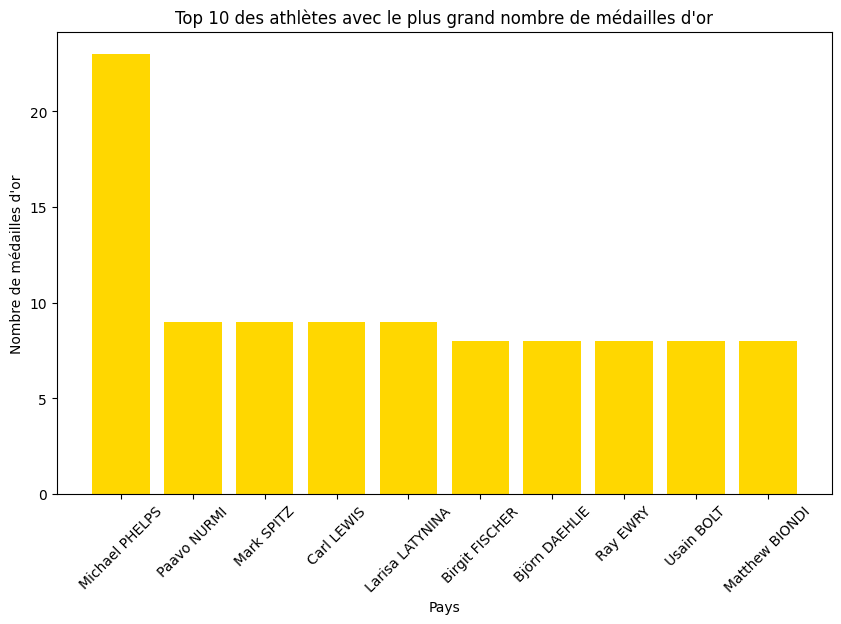

In [154]:
# Récupérer les données pour les médailles d'or par pays
gold_data = total_medals_by_country.select("athlete_full_name", "total_gold_medals").toPandas()

# Trier les données par nombre de médailles d'or
gold_data_sorted = gold_data.sort_values(by="total_gold_medals", ascending=False)

# Sélectionner uniquement le top 10
top_10_gold_data = gold_data_sorted.head(10)

# Tracer les médailles d'or pour les dix premiers pays
plt.figure(figsize=(10, 6))
plt.bar(top_10_gold_data["athlete_full_name"], top_10_gold_data["total_gold_medals"], color='gold')
plt.xlabel('Pays')
plt.ylabel('Nombre de médailles d\'or')
plt.title('Top 10 des athlètes avec le plus grand nombre de médailles d\'or')
plt.xticks(rotation=45)
plt.show()

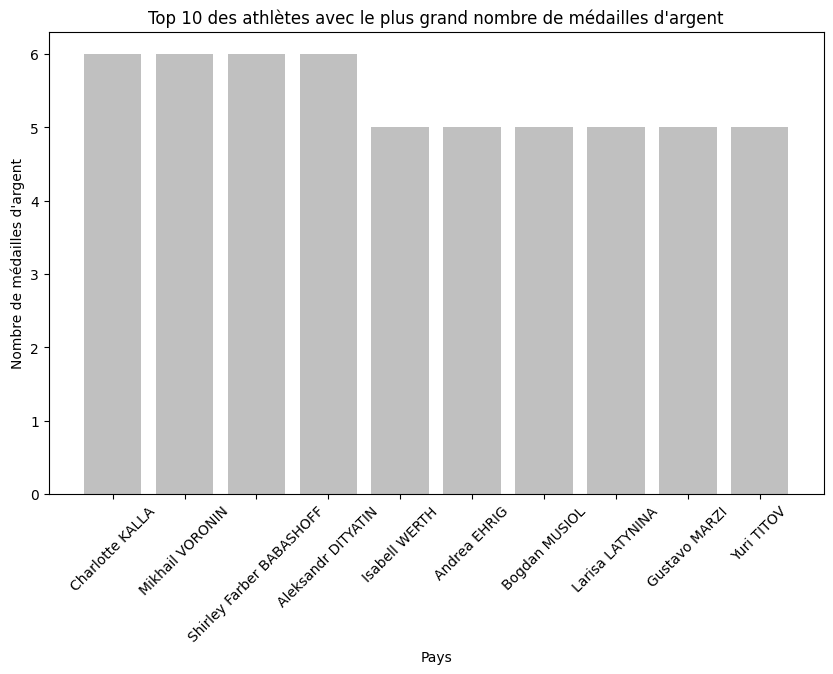

In [153]:
# Récupérer les données pour les médailles d'argent par pays
silver_data = total_medals_by_country.select("athlete_full_name", "total_silver_medals").toPandas()

# Trier les données par nombre de médailles d'argent
silver_data_sorted = silver_data.sort_values(by="total_silver_medals", ascending=False)

# Sélectionner uniquement le top 10
top_10_silver_data = silver_data_sorted.head(10)

# Tracer les médailles d'argent pour les dix premiers pays
plt.figure(figsize=(10, 6))
plt.bar(top_10_silver_data["athlete_full_name"], top_10_silver_data["total_silver_medals"], color='silver')
plt.xlabel('Pays')
plt.ylabel('Nombre de médailles d\'argent')
plt.title('Top 10 des athlètes avec le plus grand nombre de médailles d\'argent')
plt.xticks(rotation=45)
plt.show()


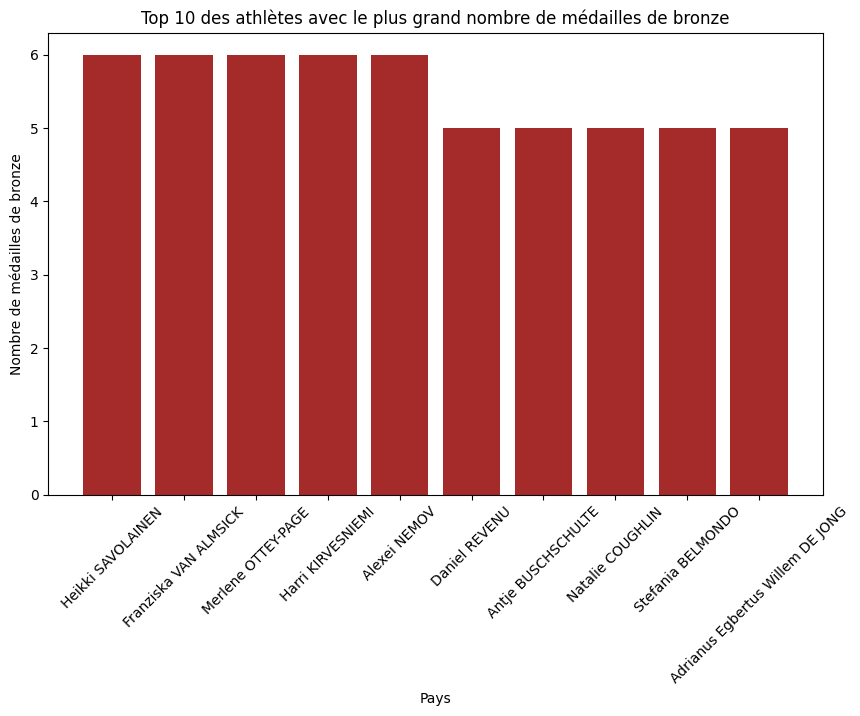

In [152]:
# Récupérer les données pour les médailles de bronze par pays
bronze_data = total_medals_by_country.select("athlete_full_name", "total_bronze_medals").toPandas()

# Trier les données par nombre de médailles de bronze
bronze_data_sorted = bronze_data.sort_values(by="total_bronze_medals", ascending=False)

# Sélectionner uniquement le top 10
top_10_bronze_data = bronze_data_sorted.head(10)

# Tracer les médailles de bronze pour les dix premiers pays
plt.figure(figsize=(10, 6))
plt.bar(top_10_bronze_data["athlete_full_name"], top_10_bronze_data["total_bronze_medals"], color='brown')
plt.xlabel('Pays')
plt.ylabel('Nombre de médailles de bronze')
plt.title('Top 10 des athlètes avec le plus grand nombre de médailles de bronze')
plt.xticks(rotation=45)
plt.show()


In [157]:
# Utiliser directement la colonne "games_participations" comme caractéristique
athlete_features_df = df.select("athlete_full_name", "games_participations", "total_medals")

# Afficher les caractéristiques créées
athlete_features_df.show()

+--------------------+--------------------+------------+
|   athlete_full_name|games_participations|total_medals|
+--------------------+--------------------+------------+
|Aadijatmiko FINARSIH|                   2|           0|
|Aage Avaldorff MEYER|                   2|           0|
| Aage Ingvar ERIKSEN|                   2|           1|
|      Aage RASMUSSEN|                   1|           0|
|       Aagje Ada KOK|                   2|           3|
| Aagw Sifried MADSEN|                   1|           0|
|         Antti AALTO|                   2|           0|
| Aarne Aatami PEUSSA|                   1|           0|
|    Aarne J. VALKAMA|                   1|           0|
|     Aarne KAINLAURI|                   1|           0|
|      Aarne KALLBERG|                   1|           0|
| Aarne Karl LINDHOLM|                   1|           1|
|      Aarne LINDROOS|                   2|           0|
|         Aarne ROINE|                   1|           0|
|      Aarne VEHKONEN|         

#Séparer les données en ensembles d'entraînement et de test

In [158]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Créer un assembleur de vecteurs pour regrouper toutes les caractéristiques en une seule colonne
feature_assembler = VectorAssembler(inputCols=["games_participations"], outputCol="features")

# Utiliser l'assembleur de vecteurs pour transformer les ensembles d'entraînement et de test
train_features = feature_assembler.transform(train_data)
test_features = feature_assembler.transform(test_data)

# Afficher les caractéristiques transformées
train_features.show()
test_features.show()

+--------------------+--------------+--------------------+------------------+---------------------+-------------------+--------------------+-------------------+--------------------+-----------+-------------+-------------+------------+--------+
|   athlete_full_name|athlete_medals|         athlete_url|athlete_year_birth|country_3_letter_code|   discipline_title|         event_title|         first_game|games_participations|gold_medals|silver_medals|bronze_medals|total_medals|features|
+--------------------+--------------+--------------------+------------------+---------------------+-------------------+--------------------+-------------------+--------------------+-----------+-------------+-------------+------------+--------+
|           DENI DENI|             0|https://olympics....|              1989|                  INA|      Weightlifting|            77kg men|        London 2012|                   2|          0|            0|            0|           0|   [2.0]|
|          . PRIYANKA|  

#VectorAssembler

In [165]:
# Créer un objet VectorAssembler pour assembler les caractéristiques
assembler = VectorAssembler(
    inputCols=["total_medals", "games_participations"],
    outputCol="features"
)

# Assembler les caractéristiques sur l'ensemble d'entraînement
train_data = assembler.transform(train_data)

# Créer un modèle Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="total_medals", numTrees=10)

# Entraîner le modèle sur l'ensemble d'entraînement
rf_model = rf.fit(train_data)

# Faire des prédictions sur l'ensemble de test
test_data = assembler.transform(test_data)
predictions_rf = rf_model.transform(test_data)

# Afficher les prédictions
predictions_rf.select("athlete_full_name", "total_medals", "prediction").show()


+--------------------+------------+--------------------+
|   athlete_full_name|total_medals|          prediction|
+--------------------+------------+--------------------+
|             . RAHUL|           0| 0.05379307495878645|
| A. Germaine GOLDING|           0| 0.05379307495878645|
|        A. TURNOVSKY|           0| 0.05379307495878645|
|Aadijatmiko FINARSIH|           0|0.018972149561470995|
|      Aage RASMUSSEN|           0| 0.05379307495878645|
|       Aagje Ada KOK|           3|  2.8531034402059148|
|    Aarne J. VALKAMA|           0| 0.05379307495878645|
|     Aarne SALOVAARA|           2|   2.184807198894086|
|          Aaron LOWE|           0| 0.05379307495878645|
|         Aaron MARCH|           0|0.026728001887237555|
|      Aaron MCINTOSH|           1|  0.9189721495614709|
|       Aaron PARCHEM|           0| 0.05379307495878645|
|       Aaron POPOOLA|           0| 0.05379307495878645|
|     Aaron SARMIENTO|           0|0.018972149561470995|
|Aatto Johannes NUORA|         

#modèle GBT

In [167]:
# Créer un modèle GBT
gbt = GBTRegressor(featuresCol="features", labelCol="total_medals", maxIter=10)

# Entraîner le modèle sur l'ensemble d'entraînement
gbt_model = gbt.fit(train_data)

# Faire des prédictions sur l'ensemble de test
predictions_gbt = gbt_model.transform(test_data)

# Afficher les prédictions
predictions_gbt.select("athlete_full_name", "total_medals", "prediction").show()


+--------------------+------------+----------+
|   athlete_full_name|total_medals|prediction|
+--------------------+------------+----------+
|             . RAHUL|           0|       0.0|
| A. Germaine GOLDING|           0|       0.0|
|        A. TURNOVSKY|           0|       0.0|
|Aadijatmiko FINARSIH|           0|       0.0|
|      Aage RASMUSSEN|           0|       0.0|
|       Aagje Ada KOK|           3|       3.0|
|    Aarne J. VALKAMA|           0|       0.0|
|     Aarne SALOVAARA|           2|       2.0|
|          Aaron LOWE|           0|       0.0|
|         Aaron MARCH|           0|       0.0|
|      Aaron MCINTOSH|           1|       1.0|
|       Aaron PARCHEM|           0|       0.0|
|       Aaron POPOOLA|           0|       0.0|
|     Aaron SARMIENTO|           0|       0.0|
|Aatto Johannes NUORA|           0|       0.0|
|   Abbas HAJI KENARI|           0|       0.0|
|      Abbey WEITZEIL|           4|       4.0|
|  Abdel Kader ZADDEM|           0|       0.0|
|Abdelamid BO

#modèle de régression linéaire

In [159]:
# Créer un modèle de régression linéaire
lr = LinearRegression(featuresCol="features", labelCol="total_medals")

# Entraîner le modèle sur les données d'entraînement
lr_model = lr.fit(train_features)

# Faire des prédictions sur les données de test
predictions = lr_model.transform(test_features)

# Afficher les prédictions
predictions.select("athlete_full_name", "total_medals", "prediction").show()

# Évaluer les performances du modèle
evaluator = RegressionEvaluator(labelCol="total_medals", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


+--------------------+------------+-------------------+
|   athlete_full_name|total_medals|         prediction|
+--------------------+------------+-------------------+
|             . RAHUL|           0|0.13444245074221908|
| A. Germaine GOLDING|           0|0.13444245074221908|
|        A. TURNOVSKY|           0|0.13444245074221908|
|Aadijatmiko FINARSIH|           0|  0.493123618569983|
|      Aage RASMUSSEN|           0|0.13444245074221908|
|       Aagje Ada KOK|           3|  0.493123618569983|
|    Aarne J. VALKAMA|           0|0.13444245074221908|
|     Aarne SALOVAARA|           2|  0.493123618569983|
|          Aaron LOWE|           0|0.13444245074221908|
|         Aaron MARCH|           0| 0.8518047863977469|
|      Aaron MCINTOSH|           1|  0.493123618569983|
|       Aaron PARCHEM|           0|0.13444245074221908|
|       Aaron POPOOLA|           0|0.13444245074221908|
|     Aaron SARMIENTO|           0|  0.493123618569983|
|Aatto Johannes NUORA|           0|0.13444245074

In [168]:
# Évaluation des performances du modèle
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="total_medals", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_gbt)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

# Optimisation du modèle (exemple : ajustement des hyperparamètres)
gbt_tuned = GBTRegressor(featuresCol="features", labelCol="total_medals", maxIter=20, maxDepth=5)
gbt_model_tuned = gbt_tuned.fit(train_data)
predictions_gbt_tuned = gbt_model_tuned.transform(test_data)

# Nouvelle évaluation des performances
rmse_tuned = evaluator.evaluate(predictions_gbt_tuned)
print("Tuned Root Mean Squared Error (RMSE) on test data =", rmse_tuned)

# Interprétation des résultats (exemple : importance des caractéristiques)
feature_importance = gbt_model_tuned.featureImportances
print("Feature Importance:", feature_importance)

Root Mean Squared Error (RMSE) on test data = 0.005210258655333872
Tuned Root Mean Squared Error (RMSE) on test data = 0.006452318267012525
Feature Importance: (2,[0,1],[0.9981570390777681,0.0018429609222319647])


#Collecter des données pour chaque discipline

In [174]:
# Collecter des données pour chaque discipline
disciplines = predictions.select('discipline_title').distinct().rdd.flatMap(lambda x: x).collect()

# Créer une fonction pour afficher le top 10 des athlètes prédits pour une discipline donnée
def plot_top_10_predictions(discipline):
    # Filtrer les prédictions pour la discipline sélectionnée
    discipline_predictions = predictions.filter(predictions['discipline_title'] == discipline)

    # Trier les prédictions par le nombre de médailles prédites en ordre décroissant
    discipline_predictions = discipline_predictions.orderBy(discipline_predictions['prediction'].desc())

    # Sélectionner les 10 premiers athlètes prédits
    top_10_predictions = discipline_predictions.limit(10)

    # Collecter les données pour le graphique
    athletes = top_10_predictions.select('athlete_full_name').rdd.flatMap(lambda x: x).collect()
    predicted_medals = top_10_predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

    # Créer le graphique
    plt.figure(figsize=(10, 6))
    plt.barh(athletes, predicted_medals, color='skyblue')
    plt.xlabel('Nombre de médailles prédites')
    plt.ylabel('Athlète')
    plt.title(f'Top 10 des athlètes prédits pour remporter des médailles dans la discipline {discipline}')
    plt.show()

# Créer une liste déroulante pour sélectionner la discipline
dropdown_discipline = widgets.Dropdown(options=disciplines, description='Discipline')

# Lier la fonction plot_top_10_predictions à la liste déroulante
interact(plot_top_10_predictions, discipline=dropdown_discipline);


interactive(children=(Dropdown(description='Discipline', options=('Tennis', 'Boxing', 'Marathon Swimming', 'Go…